In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
#Switching directories for easy access to the data
data = '/Users/alexchoe/Desktop/Capstone/m2py-master/data/all_abstracts_model/'
os.chdir(data)

In [3]:
#Opening contents of Word2Vec model
model = Word2Vec.load("all_abstract_model.model")
vocabulary = list(model.wv.vocab)

In [4]:
model.wv.__getitem__('study')

array([  4.51539   ,   4.103919  ,  -1.8394607 ,  -6.114477  ,
         6.1308594 ,   6.0427675 ,  -1.1978918 ,   1.855273  ,
        -4.160244  ,  -3.742103  ,  -0.5794198 ,   9.883354  ,
        -4.3117127 ,   4.3782854 ,   3.5364165 ,  -4.9079742 ,
        -2.0147028 ,   5.517852  ,  -2.5264072 ,   0.60432535,
        -0.90231055,   2.0508857 ,  -1.0533296 ,  -4.2132974 ,
         4.2740326 ,  -1.8519586 ,   2.927174  ,  -1.760242  ,
       -13.595478  ,   6.390037  ,   5.449058  ,   1.0620196 ,
         1.1603653 ,  -1.8674527 ,  -7.909827  ,   3.757318  ,
        -0.7085782 ,  -1.8104229 ,  -0.7972807 ,   0.24420857,
        -0.02632353,  -5.917606  ,  10.481008  ,  -3.1318085 ,
        -1.7313521 ,   2.7741985 ,   3.4522643 ,  -4.4935923 ,
         1.5952134 ,   0.79401314], dtype=float32)

In [2]:
data = '/Users/alexchoe/Desktop/Capstone/BETO2020-master/data/carbon/'
os.chdir(data)

In [5]:
#Taking in data as a dataframe for easy pre-processing
df = pd.read_excel('Carbon_SynAntList_Full_Refined.xlsx', skiprows = 1, nrows=2000)
carbon_df = df.rename(columns = {'Unnamed: 0':'index', 0:'word 1', 1:'word 2', 2:'relationship', 'Unnamed: 4':'label'})
carbon_df = carbon_df.fillna(0)
carbon_df = carbon_df[1:]

#finding which words are in the pd but not in vocabulary1
list1 = list(carbon_df['word 1'])
list2 = list(carbon_df['word 2'])
missing = list((set(list1).difference(vocabulary))) + list((set(list2).difference(vocabulary)))

#keeping only the rows in the pd that have words in vocabulary1
carbon_df = carbon_df[~carbon_df['word 1'].isin(missing)]
carbon_df = carbon_df[~carbon_df['word 2'].isin(missing)]

#reseting indices after mask
carbon_df.reset_index(inplace = True)

In [6]:
for i in range(len(carbon_df)):
    carbon_df['word 1'].iloc[i] = model.wv.__getitem__(str(carbon_df['word 1'].iloc[i]))
    carbon_df['word 2'].iloc[i] = model.wv.__getitem__(str(carbon_df['word 2'].iloc[i]))
    
    if carbon_df['relationship'].iloc[i] == 'syn' and carbon_df['label'].iloc[i] == 1:
        carbon_df['relationship'].iloc[i] = 1
    else:
        carbon_df['relationship'].iloc[i] = 0   

/Users/alexchoe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
carbon_df.head()

,level_0,index,word 1,word 2,relationship,label
0,1,1,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[0.3912109, -2.6639938, -0.4191871, -0.3595066...",1,1
1,2,2,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[0.67807263, -0.0778522, 3.3564792, -1.8280518...",1,1
2,3,3,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[-0.40175724, 0.66337395, -1.5072205, -1.73012...",0,0
3,4,4,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[2.6374276, -0.8799803, 1.9580756, -3.1686919,...",0,0
4,7,7,"[1.0246488, -5.6508703, -1.4263288, -3.1607409...","[-1.5558529, 2.824446, -3.416154, -0.963536, 0...",0,0


In [8]:
carbon_df.to_json('SYN_NN_DATA.json')

In [3]:
carbon_df = pd.read_json('SYN_NN_DATA.json', dtype = np.float32)

In [4]:
#Hyper parameters
num_epochs = 100
batch_size = 50
learning_rate = 0.008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
X = carbon_df[['word 1', 'word 2']] #Input features used to make predictions
Y = carbon_df[['relationship']] #Target feature to be predicted 
 
x_train, x_test, syn_train, syn_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

x_train.reset_index(inplace = True)
x_test.reset_index(inplace = True)
syn_train.reset_index(inplace = True)
syn_test.reset_index(inplace = True)

x1_train = x_train['word 1']
x2_train = x_train['word 2']
x1_test = x_test['word 1']
x2_test = x_test['word 2']

In [20]:
syn_train

,index,relationship
0,1369,0.0
1,87,0.0
2,418,0.0
3,453,0.0
4,56,0.0
...,...,...
1275,406,0.0
1276,593,1.0
1277,689,0.0
1278,1382,0.0


In [6]:
x_train_array = np.empty((len(x_train),100))
x_train_df = pd.DataFrame(data=x_train_array[0:,:])

x_test_array = np.empty((len(x_test),100))
x_test_df = pd.DataFrame(data=x_test_array[0:,:])

In [7]:
for i in range(len(x_train_df)):
    for u in range(len(x_train['word 2'][i])):
        x_train_df.iloc[i,u] = x_train['word 1'][i][u]
        
for i in range(len(x_train_df)):
    for u in range(len(x_train['word 2'][i])):
        x_train_df.iloc[i,(50+u)] = x_train['word 2'][i][u]

                
for i in range(len(x_test_df)):
    for u in range(len(x_test['word 1'][i])):
        x_test_df.iloc[i,u] = x_test['word 1'][i][u]
        
                
for i in range(len(x_test_df)):
    for u in range(len(x_test['word 2'][i])):
        x_test_df.iloc[i,(50+u)] = x_test['word 2'][i][u]

In [8]:
x_train_tensor = torch.tensor(x_train_df.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
syn_train_tensor = torch.tensor(syn_train.values.astype(np.float32))
#nonsyn_train_tensor = torch.tensor(nonsyn_train)

#create tensor with features and targets
#Feed in x1_train_tensor, x2_train_tensor below (separate datasets)
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, syn_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test_df.values.astype(np.float32))
syn_test_tensor = torch.tensor(syn_test.values.astype(np.float32))
#nonsyn_test_tensor = torch.tensor(nonsyn_test)

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, syn_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [9]:
#Defining the neural network
class SYN_TEST(nn.Module):

    def __init__(self, in_dims, out_dims):
        super(SYN_TEST, self).__init__()
        
        #embedding layer
        self.embedding_layer = nn.Linear(in_dims, 100)
        
        #hidden layers
        self.hidden_layer = nn.Linear(100, 32)
        self.hidden_layer1 = nn.Linear(32, 16)
        
        #output layer
        self.output_layer = nn.Linear(16,1)
        #self.syn_branch = nn.Sequential(
        #nn.Dropout(p = 0.3),
        #nn.Linear(8,16),
        #nn.Linear(16,32),
        #nn.Linear(32,8),
        #nn.Dropout(p = 0.3)
        #nn.Softplus(),
        #nn.Linear(8,2))
        
    def forward(self,x):
       
        #pass through embedding layer
        out = self.embedding_layer(x)
        
        #pass through hidden layers
        out = self.hidden_layer(out)
        out = self.hidden_layer1(out)
        
        #pass to output layer
        syn_out = self.output_layer(out)
        
        return syn_out

In [10]:
def train_model(model, training_data_set, optimizer):
    train_losses = []
    syn_train_losses = []
    train_epoch_loss = []
    syn_train_epoch_loss = []
    
    syn_losses = []
    train_total = 0
    
    #switch model to training mode
    model.train()
    syn_criterion = nn.MSELoss()
    
    for features, labels in training_data_set:
        
        model.zero_grad() #zero out any gradients from prior loops 
        syn_out = model(features) #gather model predictions for this loop
        
        #calculate error in the predictions
        syn_loss = syn_criterion(syn_out, labels)
        total_loss = syn_loss
        
        #BACKPROPAGATE LIKE A MF
        torch.autograd.backward([syn_loss])
        optimizer.step()
        
        #save loss for this batch
        train_losses.append(total_loss.item())
        train_total+=1
        
        syn_train_losses.append(syn_loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    syn_train_epoch_loss.append(sum(syn_train_losses)/train_total)
    
    #update progress bar
    print(f"Total Epoch Training Loss is: {train_epoch_loss}")
    
    return train_epoch_loss, syn_train_epoch_loss

In [ ]:
def eval_model(model, testing_data_set, optimizer):
    #evaluate the model
    model.eval()
    
    syn_criterion = nn.MSELoss()
    #accuracy = #total number of correct predictions divided by the total number of predictions
    
    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        test_losses = []
        syn_test_losses = []
        syn_test_acc_list = []
        
        test_total = 0
        element_count = 0
        correct = 0

        for inputs, labels in testing_data_set:
            inputs = inputs.to(device)
            labels = labels.to(device)

            syn_out = model(inputs)

            # calculate loss per batch of testing data
            syn_test_loss = syn_criterion(syn_out, labels)
            
            test_loss = syn_test_loss
            
            test_losses.append(test_loss.item())
            syn_test_losses.append(syn_test_loss.item())
            test_total += 1 
            
            for x, y in zip(syn_out, labels):
                if x == y[1]:
                    correct += 1
                    element_count += 1

                else:
                    element_count += 1

        test_epoch_loss = sum(test_losses)/test_total
        syn_test_epoch_loss = sum(syn_test_losses)/test_total
        
        syn_acc = (correct/element_count) * 100
        syn_test_acc_list.append(syn_acc)
        
        print(f"Total Epoch Testing Loss is: {test_epoch_loss}")
        print(f"Accuracy of the Synonym Classifier is: {syn_acc}")
    
    return test_epoch_loss, syn_test_epoch_loss, syn_acc

In [12]:
# Instantiate our beautiful NN model
# takes in 
# predicts synonymy
model = SYN_TEST(in_dims = 100, out_dims = 2).to(device)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [19]:
#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []

test_epoch_losses = []
syn_test_epoch_losses = []

syn_test_epoch_accuracies = []


for epoch in range(num_epochs):
    
    train_epoch_loss, syn_train_epoch_loss  = train_model(model = model, training_data_set = training_data_set, optimizer = optimizer)
    
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
   
    test_epoch_loss, syn_test_epoch_loss, syn_acc = eval_model(model = model, testing_data_set = testing_data_set, optimizer = optimizer)
    
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    
    test_epoch_loss, syn_test_epoch_loss, syn_acc = eval_model(model = model, testing_data_set = testing_data_set, optimizer = optimizer)
    
    syn_test_epoch_accuracies.append(syn_acc)

Total Epoch Training Loss is: [226132.2938701923]
tensor([604.5976]) tensor([1.3940e+03, 1.0000e+00])
tensor([504.4288]) tensor([1.0620e+03, 1.0000e+00])
tensor([438.2862]) tensor([791.,   0.])
tensor([475.1859]) tensor([775.,   0.])
tensor([55.3215]) tensor([487.,   1.])
tensor([527.4307]) tensor([1058.,    0.])
tensor([707.8050]) tensor([1279.,    0.])
tensor([474.3626]) tensor([945.,   1.])
tensor([108.4486]) tensor([151.,   0.])
tensor([297.2042]) tensor([624.,   0.])
tensor([277.0117]) tensor([837.,   1.])
tensor([319.8620]) tensor([667.,   0.])
tensor([335.1491]) tensor([504.,   0.])
tensor([163.4954]) tensor([275.,   1.])
tensor([270.1232]) tensor([585.,   1.])
tensor([772.5132]) tensor([1517.,    0.])
tensor([130.0337]) tensor([260.,   1.])
tensor([629.2669]) tensor([1288.,    0.])
tensor([444.3885]) tensor([898.,   1.])
tensor([313.0511]) tensor([703.,   1.])
tensor([399.9359]) tensor([508.,   0.])
tensor([292.7784]) tensor([1.1200e+03, 1.0000e+00])
tensor([641.1532]) tensor([

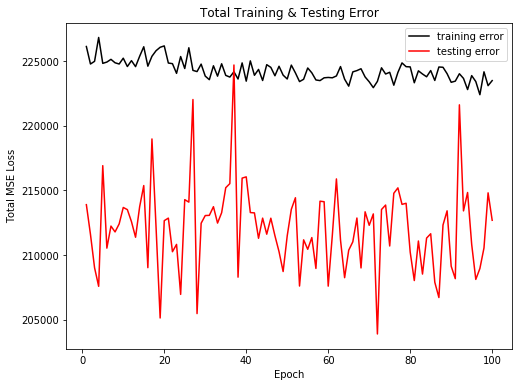

In [20]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()

#fig, ax = plt.subplots(figsize = (8,6))
# plt.plot(epochs, train_epoch_accuracy, c = 'k', label = 'training accuracy')
#plt.plot(epochs, pce_test_epoch_accuracies, c = 'k', label = 'pce accuracy')
#plt.plot(epochs, voc_test_epoch_accuracies, c = 'r', label = 'voc accuracy')
#plt.plot(epochs, jsc_test_epoch_accuracies, c = 'g', label = 'jsc accuracy')
#plt.plot(epochs, ff_test_epoch_accuracies, c = 'b', label = 'ff accuracy')
#plt.legend(loc = 'lower right')
#plt.title("Branch Mean Absolute Percent Error")
#ax.set_xlabel('Epoch')
#ax.set_ylabel('MAPE')
#plt.show()